In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
seed = 161
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  STI6WR1Z_13_41_58
NN-MODEL FILENAME:  ./models/STI6WR1Z_13_41_58_NN.pt


In [6]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [7]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [8]:
T_LR           = 1e-1
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [9]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 100000

In [10]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 7000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  30


In [11]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
        bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

        good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [13]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.925
LENGTH_ABS_MIN = 0.375

In [14]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 10
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  10


In [15]:
def mp_node_run(node_id, boundary, iteration):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
    
    # Mean values of pole length deviate by 40% from original value
    scaling_factor = 0.8 + (1.8 - 0.8) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = boundary
    ###############################################
#     LENGTH_MAX = length_mean + 0.05
#     LENGTH_MIN = length_mean - 0.05
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN, LENGTH_MAX, LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
                                    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
    
#     my_dqn = D3QN()
    my_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    my_dqn.eval_net.eval()
#     my_QFILE   = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#     my_Q_TABLE = np.load(my_QFILE)
    my_Q_TABLE = my_dqn.get_qvals(state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
    if iteration < 3:
        my_EPSILON   = (iteration+1) * 0.2 + np.random.uniform(-0.1,0.1)
    else:
        my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR = min(1e-4, T_LR/(10**iteration)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

                     
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
                my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]
    
#     LENGTH_MAX = exp_rec[:,4].max() + 0.25*np.abs(exp_rec[:,4].max())
#     LENGTH_MIN = exp_rec[:,4].min() - 0.25*np.abs(exp_rec[:,4].min())

    # CLAMP STATE VALUE BORDERS
    ###############################################
#     C_POS_MAX = clamp(C_POS_ABS_MIN, C_POS_MAX, C_POS_ABS_MAX)
#     C_POS_MIN = clamp(C_POS_ABS_MIN, C_POS_MIN, C_POS_ABS_MAX) 

#     C_VEL_MAX = clamp(C_VEL_ABS_MIN, C_VEL_MAX, C_VEL_ABS_MAX)
#     C_VEL_MIN = clamp(C_VEL_ABS_MIN, C_VEL_MIN, C_VEL_ABS_MAX) 

#     P_ANG_MAX = clamp(P_ANG_ABS_MIN, P_ANG_MAX, P_ANG_ABS_MAX)
#     P_ANG_MIN = clamp(P_ANG_ABS_MIN, P_ANG_MIN, P_ANG_ABS_MAX) 

#     P_VEL_MAX = clamp(P_VEL_ABS_MIN, P_VEL_MAX, P_VEL_ABS_MAX)
#     P_VEL_MIN = clamp(P_VEL_ABS_MIN, P_VEL_MIN, P_VEL_ABS_MAX) 

    LENGTH_MAX = clamp(LENGTH_ABS_MIN, LENGTH_MAX + 0.075, LENGTH_ABS_MAX)
    LENGTH_MIN = clamp(LENGTH_ABS_MIN, LENGTH_MIN - 0.075, LENGTH_ABS_MAX)
    ###############################################
    
    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [16]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [17]:
iteration = 0
my_dqn = D3QN()
dqn = D3QN()
# INITIALIZE MODEL FILE
torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

In [18]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# INITIALIZE QFILES FOR EACH NODE
#############################################################################################################################################
# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]

#  # SET STATE VALUE BORDERS
# ###############################################
# [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#  C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = init_node_boundary
# ###############################################

# # CREATE STATE COMBINATIONS
# ###############################################

# init_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
#                                     [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
#                                     [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
# ###############################################

# # GET Q-VALUES 
# start = timeit.default_timer()
# % memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)
# stop = timeit.default_timer()
# print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# # SAVE QFILE
# for node_id in range(NO_OF_NODES):
#     node_QFILE = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#     np.save(node_QFILE, init_q_table)
# #############################################################################################################################################

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES



ITERATION # 0
MEAN TABULAR EPSILON =  0.2
TABULAR LR      =  0.01
SMALLEST TIMESTEP in ITERATION 0: 8
REAL TIME TO GENERATE 22546 EXPERIENCES:0:00:19.070269


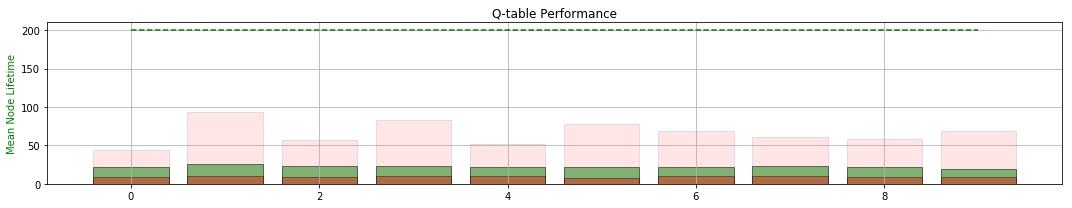

GOOD MEMORY COUNTER:  21546
BAD MEMORY COUNTER:  1000
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  150.955
Validating... MEAN TIME:  153.365
Validating... MEAN TIME:  156.54
Validating... MEAN TIME:  138.95
Validating... MEAN TIME:  153.12
TRAINING TIME:0:00:42.028281


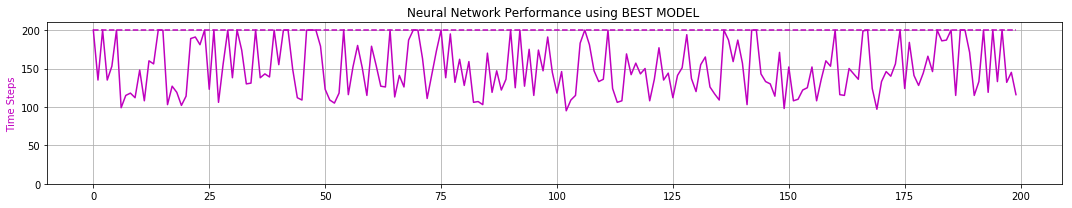

0 -max- [ 0.260  1.785  0.209  2.499  0.550]
0 -min- [-0.177 -1.575 -0.209 -2.743  0.375]

1 -max- [ 0.518  1.912  0.209  2.782  0.599]
1 -min- [-0.405 -1.718 -0.209 -2.578  0.400]

2 -max- [ 0.368  2.092  0.208  2.287  0.650]
2 -min- [-0.193 -1.406 -0.209 -2.608  0.450]

3 -max- [ 0.767  1.556  0.209  2.106  0.700]
3 -min- [-0.366 -1.365 -0.209 -2.047  0.500]

4 -max- [ 0.458  1.667  0.209  2.708  0.750]
4 -min- [-0.199 -1.741 -0.209 -2.359  0.551]

5 -max- [ 0.374  1.610  0.209  2.503  0.800]
5 -min- [-0.693 -1.928 -0.209 -2.492  0.600]

6 -max- [ 0.726  1.899  0.207  2.132  0.849]
6 -min- [-0.141 -1.360 -0.209 -2.683  0.650]

7 -max- [ 0.400  1.744  0.209  1.911  0.900]
7 -min- [-0.285 -1.332 -0.209 -2.442  0.701]

8 -max- [ 0.393  2.105  0.209  1.984  0.925]
8 -min- [-0.167 -1.318 -0.209 -2.518  0.750]

9 -max- [ 0.396  1.976  0.207  2.657  0.925]
9 -min- [-0.312 -1.948 -0.209 -2.593  0.800]



ITERATION # 1
MEAN TABULAR EPSILON =  0.4
TABULAR LR      =  0.01
SMALLEST TIMESTEP in I

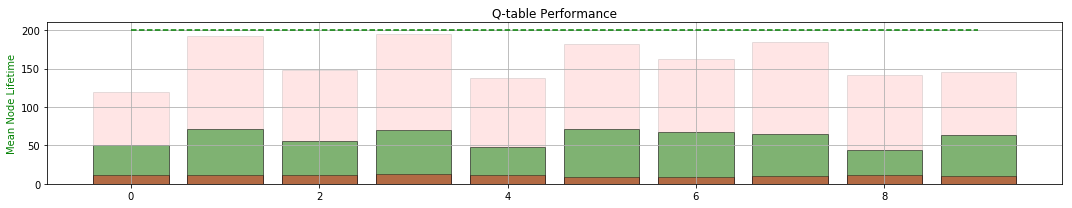

GOOD MEMORY COUNTER:  81098
BAD MEMORY COUNTER:  2000
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  160.47
Validating... MEAN TIME:  148.625
Validating... MEAN TIME:  156.26
Validating... MEAN TIME:  164.275
Validating... MEAN TIME:  156.585
TRAINING TIME:0:00:41.506690


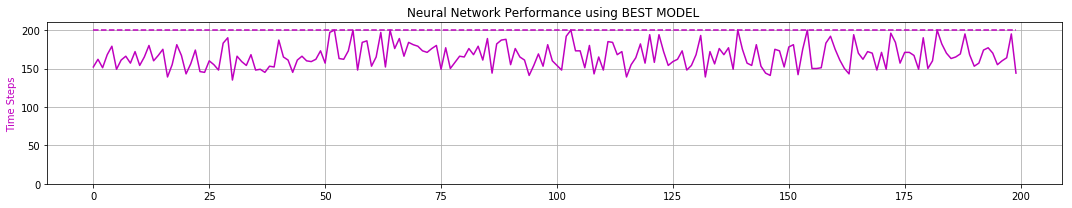

0 -max- [ 0.776  1.703  0.209  2.298  0.549]
0 -min- [-1.067 -2.089 -0.209 -2.148  0.375]

1 -max- [ 1.044  1.756  0.208  2.769  0.600]
1 -min- [-1.696 -2.417 -0.209 -2.662  0.401]

2 -max- [ 0.872  2.044  0.209  2.046  0.650]
2 -min- [-1.235 -1.940 -0.209 -2.087  0.450]

3 -max- [ 0.751  1.933  0.208  2.075  0.699]
3 -min- [-1.223 -2.321 -0.209 -2.428  0.500]

4 -max- [ 1.414  1.674  0.209  2.584  0.749]
4 -min- [-1.181 -2.031 -0.209 -2.094  0.550]

5 -max- [ 1.128  1.710  0.208  2.366  0.799]
5 -min- [-1.233 -2.078 -0.209 -2.207  0.600]

6 -max- [ 0.821  2.296  0.208  2.211  0.849]
6 -min- [-1.201 -2.084 -0.209 -3.067  0.650]

7 -max- [ 0.833  1.761  0.209  1.983  0.899]
7 -min- [-1.339 -2.282 -0.209 -2.492  0.700]

8 -max- [ 0.867  2.117  0.209  2.317  0.925]
8 -min- [-1.290 -2.038 -0.209 -2.507  0.750]

9 -max- [ 0.680  1.768  0.209  2.450  0.925]
9 -min- [-1.226 -2.223 -0.209 -2.200  0.801]



ITERATION # 2
MEAN TABULAR EPSILON =  0.6000000000000001
TABULAR LR      =  0.01
SMALLES

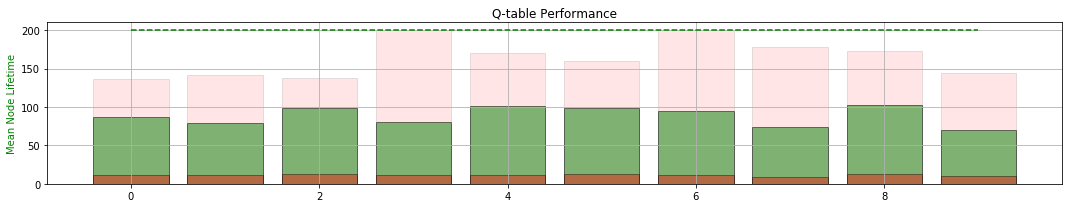

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  2997
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  137.69
Validating... MEAN TIME:  135.155
Validating... MEAN TIME:  146.715
Validating... MEAN TIME:  137.855
Validating... MEAN TIME:  137.395
TRAINING TIME:0:00:38.718094


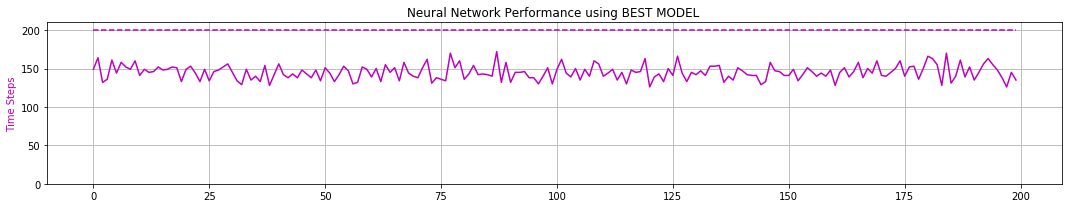

0 -max- [ 0.205  1.328  0.126  1.428  0.550]
0 -min- [-2.385 -2.929 -0.209 -2.192  0.375]

1 -max- [ 0.179  1.232  0.201  1.853  0.599]
1 -min- [-2.383 -3.093 -0.209 -2.084  0.400]

2 -max- [ 0.212  1.216  0.208  1.707  0.650]
2 -min- [-2.391 -2.912 -0.209 -1.978  0.450]

3 -max- [ 0.403  1.507  0.192  1.523  0.700]
3 -min- [-2.394 -2.946 -0.209 -2.087  0.500]

4 -max- [ 0.196  1.197  0.187  1.730  0.749]
4 -min- [-2.396 -2.973 -0.209 -1.729  0.550]

5 -max- [ 0.194  1.167  0.209  1.587  0.799]
5 -min- [-2.397 -3.340 -0.209 -1.756  0.600]

6 -max- [ 0.383  1.212  0.198  1.414  0.850]
6 -min- [-2.397 -2.962 -0.209 -1.922  0.650]

7 -max- [ 0.202  1.401  0.207  1.952  0.900]
7 -min- [-2.396 -3.123 -0.209 -2.116  0.700]

8 -max- [ 0.194  1.201  0.206  2.150  0.925]
8 -min- [-2.399 -3.307 -0.209 -2.241  0.750]

9 -max- [ 0.182  1.608  0.206  2.167  0.925]
9 -min- [-2.393 -2.950 -0.209 -2.358  0.800]



ITERATION # 3
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in 

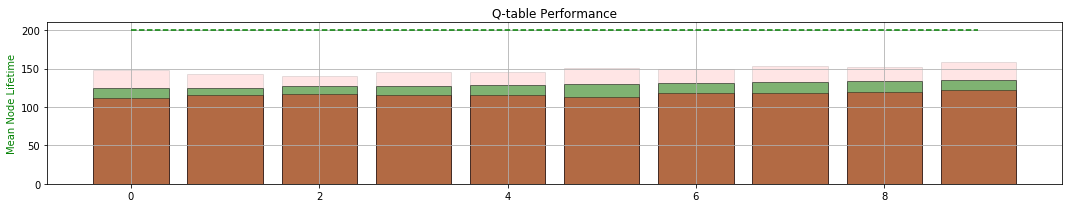

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  3997
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  134.965
Validating... MEAN TIME:  139.61
Validating... MEAN TIME:  130.555
Validating... MEAN TIME:  152.105
Validating... MEAN TIME:  140.595
TRAINING TIME:0:00:38.214943


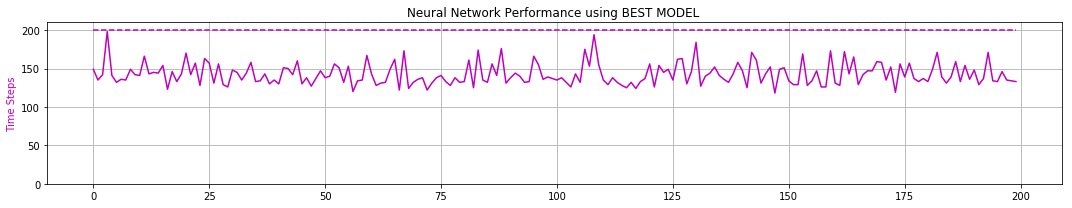

0 -max- [ 0.146  0.814  0.050  0.913  0.550]
0 -min- [-2.400 -2.959 -0.186 -1.207  0.375]

1 -max- [ 0.127  0.751  0.048  0.936  0.600]
1 -min- [-2.400 -2.933 -0.196 -1.129  0.400]

2 -max- [ 0.145  0.823  0.049  0.969  0.649]
2 -min- [-2.399 -2.932 -0.208 -1.189  0.451]

3 -max- [ 0.141  0.989  0.050  1.152  0.699]
3 -min- [-2.399 -2.929 -0.202 -1.501  0.500]

4 -max- [ 0.131  0.779  0.051  0.957  0.750]
4 -min- [-2.400 -2.938 -0.209 -1.130  0.550]

5 -max- [ 0.129  0.786  0.049  0.933  0.800]
5 -min- [-2.400 -2.974 -0.200 -1.203  0.600]

6 -max- [ 0.126  0.807  0.049  0.903  0.850]
6 -min- [-2.399 -2.934 -0.209 -1.187  0.651]

7 -max- [ 0.137  0.807  0.048  1.012  0.900]
7 -min- [-2.398 -2.934 -0.208 -1.121  0.700]

8 -max- [ 0.120  0.812  0.050  0.970  0.925]
8 -min- [-2.400 -2.773 -0.208 -1.204  0.750]

9 -max- [ 0.132  0.816  0.049  1.021  0.925]
9 -min- [-2.399 -2.780 -0.208 -1.089  0.801]



ITERATION # 4
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in 

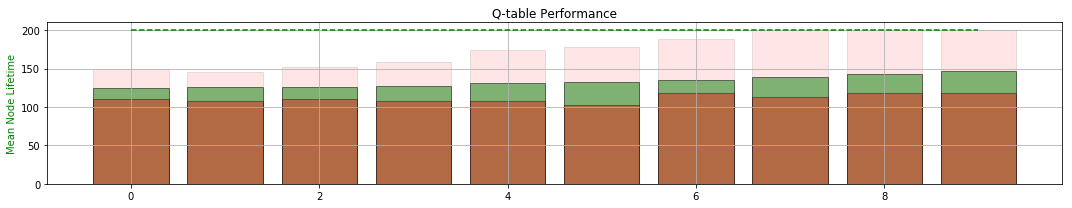

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  4982
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  184.5
Validating... MEAN TIME:  161.585
Validating... MEAN TIME:  181.325
Validating... MEAN TIME:  130.005
Validating... MEAN TIME:  129.845
TRAINING TIME:0:00:40.964185


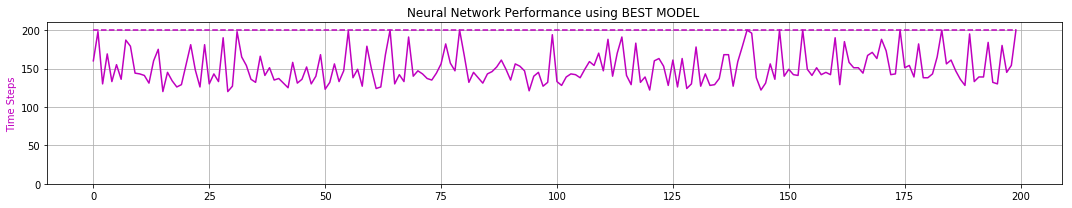

0 -max- [ 0.118  0.612  0.048  0.702  0.550]
0 -min- [-2.396 -2.965 -0.209 -0.931  0.375]

1 -max- [ 0.108  0.626  0.049  0.670  0.600]
1 -min- [-2.397 -2.971 -0.209 -1.022  0.401]

2 -max- [ 0.116  0.634  0.050  0.672  0.650]
2 -min- [-2.400 -2.971 -0.209 -1.049  0.451]

3 -max- [ 0.101  0.607  0.050  0.670  0.699]
3 -min- [-2.399 -3.106 -0.209 -0.960  0.500]

4 -max- [ 0.127  0.629  0.049  0.702  0.749]
4 -min- [-2.397 -2.968 -0.209 -0.923  0.550]

5 -max- [ 0.104  0.764  0.049  0.726  0.799]
5 -min- [-2.399 -2.974 -0.209 -1.098  0.601]

6 -max- [ 0.115  0.625  0.048  0.727  0.850]
6 -min- [-2.397 -2.943 -0.209 -0.971  0.652]

7 -max- [ 0.097  0.621  0.050  0.703  0.900]
7 -min- [-2.400 -2.956 -0.209 -0.925  0.700]

8 -max- [ 0.531  0.738  0.049  1.043  0.925]
8 -min- [-2.398 -2.948 -0.209 -1.161  0.752]

9 -max- [ 0.599  0.579  0.048  0.774  0.925]
9 -min- [-2.399 -2.933 -0.209 -1.121  0.800]



ITERATION # 5
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in 

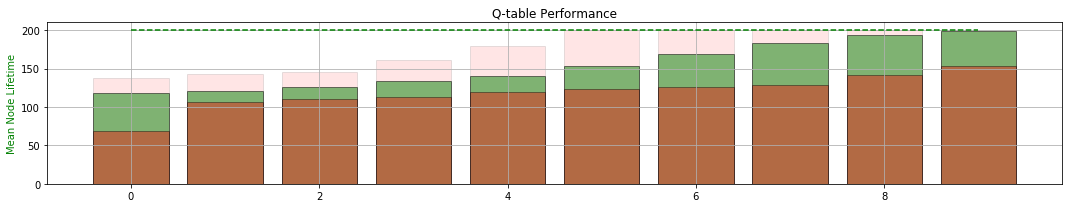

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  5743
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  187.385
Validating... MEAN TIME:  199.87
Validating... MEAN TIME:  150.94
Validating... MEAN TIME:  122.845
Validating... MEAN TIME:  158.88
TRAINING TIME:0:00:42.372888


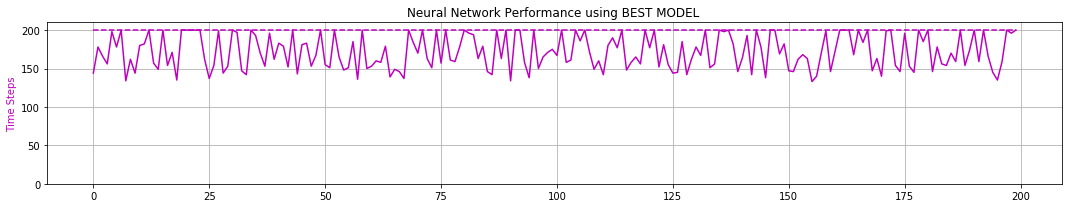

0 -max- [ 0.114  0.627  0.049  0.774  0.550]
0 -min- [-2.222 -2.700 -0.209 -1.294  0.375]

1 -max- [ 0.123  0.629  0.050  0.757  0.600]
1 -min- [-2.142 -2.578 -0.209 -1.028  0.401]

2 -max- [ 0.100  0.771  0.050  0.730  0.650]
2 -min- [-2.219 -2.593 -0.209 -1.096  0.450]

3 -max- [ 0.134  0.629  0.049  0.702  0.698]
3 -min- [-2.271 -2.566 -0.209 -0.976  0.501]

4 -max- [ 0.109  0.726  0.049  0.767  0.750]
4 -min- [-2.232 -2.614 -0.209 -1.044  0.550]

5 -max- [ 0.115  0.625  0.048  0.835  0.799]
5 -min- [-2.241 -2.512 -0.209 -0.983  0.600]

6 -max- [ 0.153  0.631  0.050  0.896  0.849]
6 -min- [-2.141 -2.405 -0.209 -1.142  0.650]

7 -max- [ 1.268  0.964  0.055  0.860  0.900]
7 -min- [-2.102 -2.222 -0.209 -0.969  0.701]

8 -max- [ 1.669  1.162  0.048  0.815  0.925]
8 -min- [-2.177 -2.226 -0.209 -1.049  0.750]

9 -max- [ 2.254  1.515  0.057  0.869  0.925]
9 -min- [-2.037 -2.026 -0.209 -1.061  0.801]



ITERATION # 6
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in 

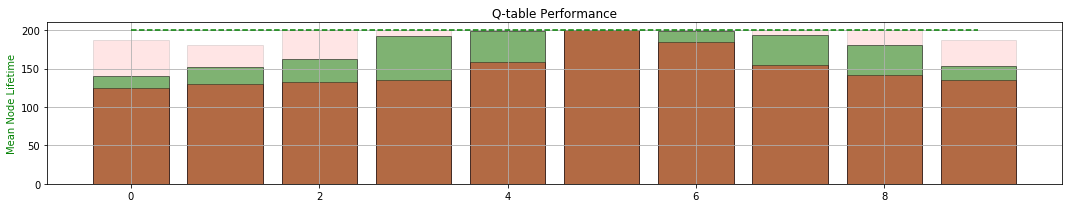

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  6306
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  196.39
Validating... MEAN TIME:  199.655
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:49.190003


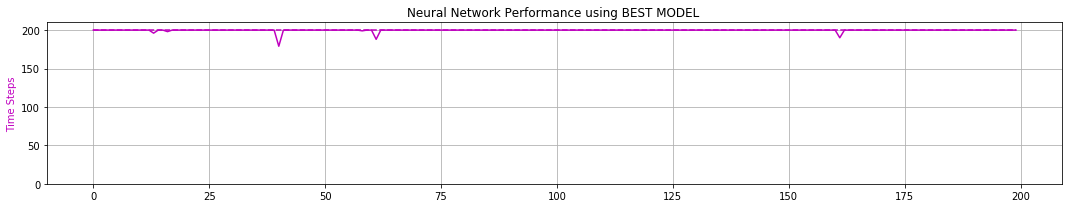

0 -max- [ 0.128  0.625  0.050  0.682  0.550]
0 -min- [-2.400 -2.954 -0.209 -0.948  0.375]

1 -max- [ 0.111  0.742  0.050  0.763  0.600]
1 -min- [-2.392 -2.932 -0.209 -1.140  0.400]

2 -max- [ 0.218  0.584  0.049  0.698  0.648]
2 -min- [-2.385 -2.738 -0.209 -1.085  0.451]

3 -max- [ 0.326  0.712  0.049  1.111  0.700]
3 -min- [-2.344 -2.424 -0.209 -0.988  0.501]

4 -max- [ 1.045  0.887  0.059  0.823  0.749]
4 -min- [-2.266 -2.373 -0.209 -1.041  0.550]

5 -max- [ 1.667  1.254  0.088  0.849  0.799]
5 -min- [-1.501 -0.954 -0.110 -0.874  0.601]

6 -max- [ 2.395  2.172  0.113  0.877  0.850]
6 -min- [-0.712 -0.732 -0.061 -0.801  0.650]

7 -max- [ 2.400  2.531  0.161  0.861  0.900]
7 -min- [-0.127 -0.609 -0.049 -0.804  0.700]

8 -max- [ 2.400  2.593  0.154  1.078  0.925]
8 -min- [-0.166 -0.774 -0.049 -0.679  0.750]

9 -max- [ 2.400  2.893  0.198  0.893  0.925]
9 -min- [-0.130 -0.616 -0.050 -0.965  0.800]



ITERATION # 7
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in 

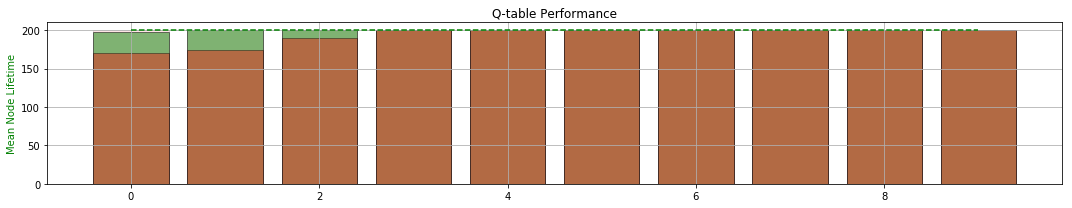

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  6332
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:49.941891


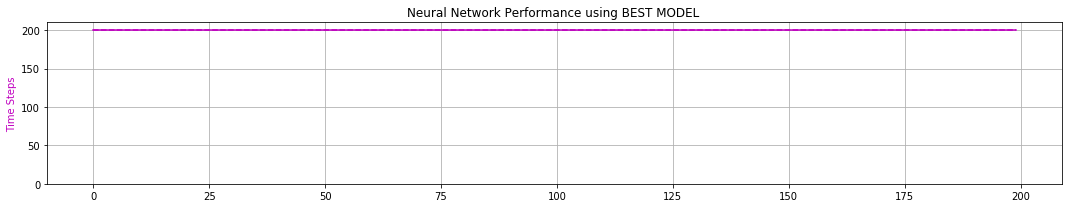

0 -max- [ 0.125  0.577  0.050  0.800  0.550]
0 -min- [-2.196 -2.195 -0.209 -0.845  0.375]

1 -max- [ 0.280  0.727  0.049  0.834  0.600]
1 -min- [-2.070 -1.850 -0.205 -0.864  0.400]

2 -max- [ 0.527  0.730  0.049  0.780  0.649]
2 -min- [-2.165 -1.866 -0.205 -0.892  0.451]

3 -max- [ 0.532  0.721  0.062  0.843  0.698]
3 -min- [-1.870 -1.686 -0.171 -0.825  0.501]

4 -max- [ 1.129  0.798  0.050  0.849  0.749]
4 -min- [-2.082 -1.677 -0.198 -0.860  0.551]

5 -max- [ 1.237  0.933  0.066  0.923  0.800]
5 -min- [-1.649 -1.133 -0.128 -0.903  0.600]

6 -max- [ 1.492  1.285  0.092  0.930  0.850]
6 -min- [-1.697 -1.119 -0.126 -0.871  0.650]

7 -max- [ 1.811  1.173  0.085  0.869  0.900]
7 -min- [-1.705 -0.939 -0.111 -0.894  0.700]

8 -max- [ 1.698  1.086  0.102  0.885  0.925]
8 -min- [-1.444 -0.799 -0.050 -0.804  0.751]

9 -max- [ 2.161  1.521  0.073  0.875  0.925]
9 -min- [-0.206 -0.577 -0.049 -0.736  0.800]



ITERATION # 8
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in 

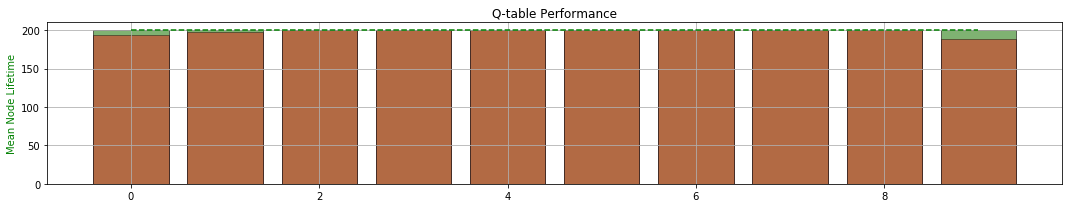

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  6337
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.96
Validating... MEAN TIME:  199.605
TRAINING TIME:0:00:50.556107


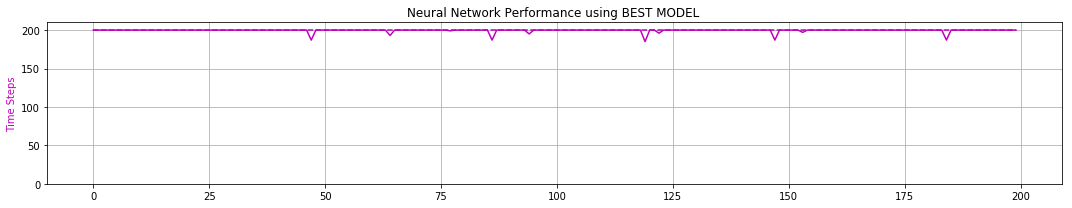

0 -max- [ 0.169  0.568  0.049  0.869  0.550]
0 -min- [-2.179 -1.905 -0.207 -1.263  0.375]

1 -max- [ 0.272  0.577  0.049  0.836  0.599]
1 -min- [-2.169 -1.865 -0.207 -1.020  0.401]

2 -max- [ 0.358  0.577  0.048  0.843  0.648]
2 -min- [-1.424 -0.975 -0.058 -0.845  0.451]

3 -max- [ 0.905  0.954  0.050  0.849  0.699]
3 -min- [-1.420 -0.970 -0.053 -1.001  0.501]

4 -max- [ 1.027  0.912  0.052  1.000  0.750]
4 -min- [-0.473 -0.564 -0.050 -0.901  0.550]

5 -max- [ 1.159  0.977  0.056  0.877  0.800]
5 -min- [-0.436 -0.605 -0.052 -0.863  0.600]

6 -max- [ 1.528  0.985  0.054  0.887  0.850]
6 -min- [-0.481 -0.602 -0.049 -0.845  0.650]

7 -max- [ 1.536  0.996  0.054  0.920  0.900]
7 -min- [-0.377 -0.625 -0.050 -0.880  0.701]

8 -max- [ 1.859  1.333  0.074  0.957  0.925]
8 -min- [-0.097 -0.617 -0.053 -0.885  0.750]

9 -max- [ 2.383  1.534  0.069  1.082  0.925]
9 -min- [-0.134 -0.822 -0.049 -0.924  0.800]



ITERATION # 9
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in 

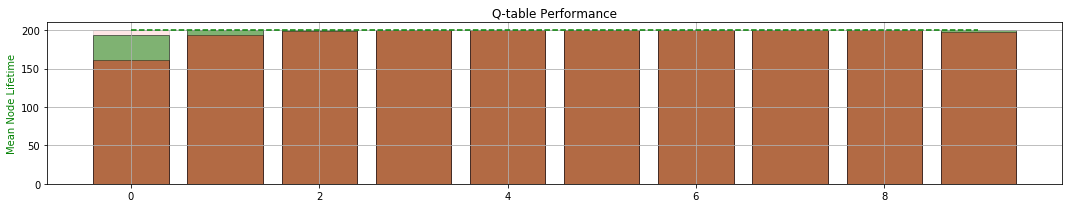

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  6388
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  188.815
Validating... MEAN TIME:  199.865
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:49.613124


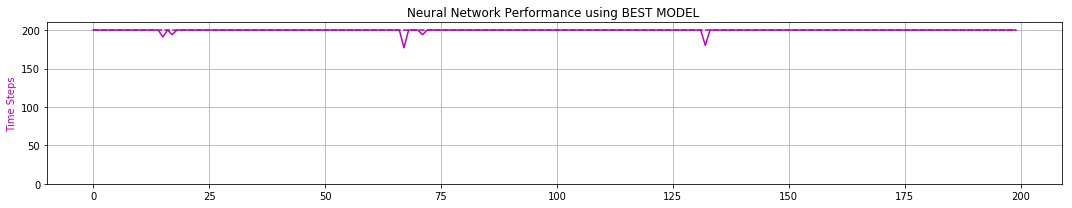

0 -max- [ 0.133  0.765  0.049  0.874  0.550]
0 -min- [-2.298 -2.167 -0.209 -1.155  0.375]

1 -max- [ 0.136  0.585  0.048  0.708  0.599]
1 -min- [-2.203 -1.878 -0.206 -0.867  0.400]

2 -max- [ 0.249  0.554  0.050  0.895  0.647]
2 -min- [-2.209 -1.852 -0.204 -0.860  0.450]

3 -max- [ 0.369  0.723  0.052  0.865  0.700]
3 -min- [-1.813 -1.319 -0.146 -0.886  0.500]

4 -max- [ 0.782  0.734  0.056  0.863  0.750]
4 -min- [-1.567 -0.957 -0.103 -0.845  0.550]

5 -max- [ 0.786  0.720  0.054  0.869  0.800]
5 -min- [-0.924 -0.777 -0.049 -0.845  0.600]

6 -max- [ 1.113  0.805  0.053  0.885  0.850]
6 -min- [-0.600 -0.627 -0.050 -0.878  0.651]

7 -max- [ 1.523  0.980  0.072  1.001  0.900]
7 -min- [-0.206 -0.577 -0.049 -0.963  0.700]

8 -max- [ 1.995  1.166  0.060  0.947  0.925]
8 -min- [-0.400 -0.569 -0.049 -0.865  0.750]

9 -max- [ 2.382  1.521  0.079  1.032  0.925]
9 -min- [-0.135 -0.598 -0.049 -0.974  0.801]



ITERATION # 10
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

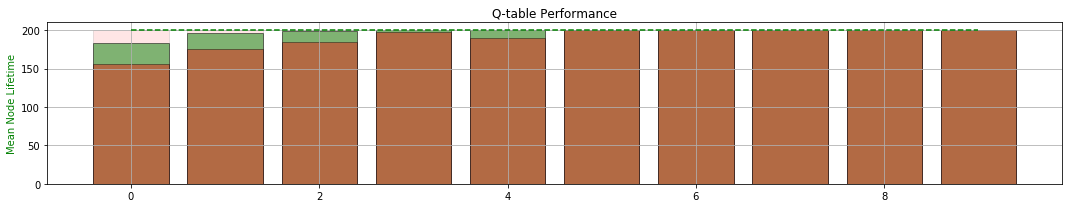

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  6525
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:50.320525


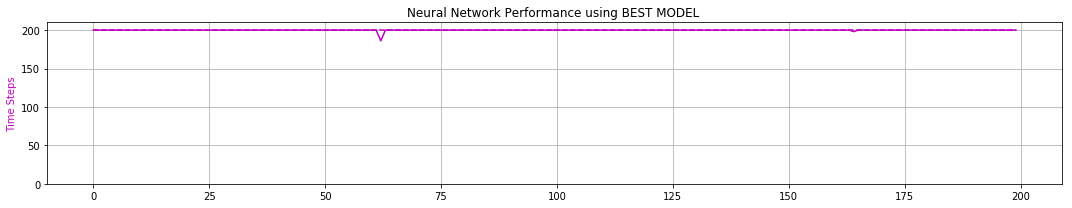

0 -max- [ 0.117  0.581  0.052  0.721  0.550]
0 -min- [-2.334 -2.249 -0.209 -1.060  0.375]

1 -max- [ 0.105  0.600  0.050  0.972  0.600]
1 -min- [-2.270 -2.164 -0.209 -1.227  0.401]

2 -max- [ 0.199  0.609  0.049  1.127  0.650]
2 -min- [-2.143 -1.959 -0.205 -0.915  0.451]

3 -max- [ 0.131  0.579  0.048  0.818  0.700]
3 -min- [-2.136 -1.865 -0.208 -0.871  0.500]

4 -max- [ 0.291  0.566  0.054  0.692  0.750]
4 -min- [-2.213 -1.872 -0.207 -0.845  0.551]

5 -max- [ 0.348  0.614  0.053  0.770  0.800]
5 -min- [-1.880 -1.320 -0.172 -0.843  0.601]

6 -max- [ 0.574  0.754  0.055  0.868  0.850]
6 -min- [-1.363 -1.128 -0.071 -0.864  0.650]

7 -max- [ 0.723  0.784  0.054  0.853  0.900]
7 -min- [-0.557 -0.565 -0.049 -0.875  0.700]

8 -max- [ 0.691  0.762  0.051  0.862  0.925]
8 -min- [-0.400 -0.593 -0.049 -0.885  0.751]

9 -max- [ 1.060  0.923  0.049  0.886  0.925]
9 -min- [-0.333 -0.609 -0.050 -0.895  0.800]



ITERATION # 11
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

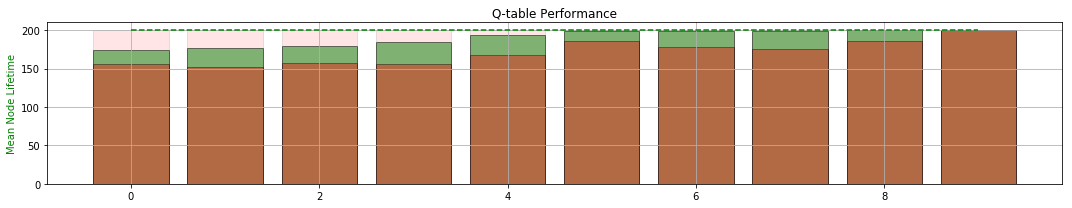

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  7007
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.995
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.96
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.87
TRAINING TIME:0:00:49.808238


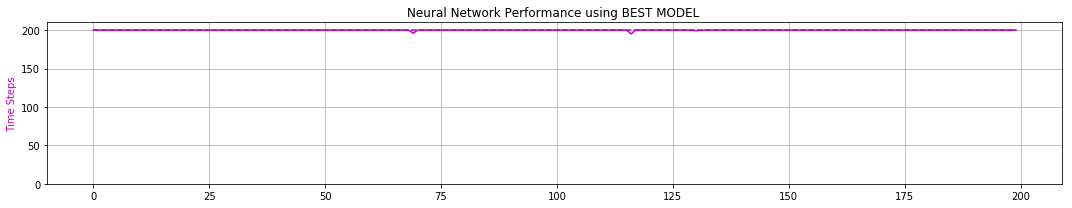

0 -max- [ 0.114  0.600  0.050  0.703  0.549]
0 -min- [-2.394 -2.570 -0.209 -0.992  0.375]

1 -max- [ 0.126  0.577  0.049  0.976  0.599]
1 -min- [-2.387 -2.400 -0.209 -0.886  0.402]

2 -max- [ 0.134  0.579  0.048  0.717  0.650]
2 -min- [-2.375 -2.393 -0.209 -1.127  0.450]

3 -max- [ 0.117  0.560  0.049  0.722  0.699]
3 -min- [-2.397 -2.233 -0.209 -0.872  0.501]

4 -max- [ 0.157  0.545  0.050  0.709  0.749]
4 -min- [-2.316 -2.194 -0.209 -0.941  0.551]

5 -max- [ 0.148  0.435  0.050  0.803  0.800]
5 -min- [-2.334 -2.187 -0.209 -0.965  0.600]

6 -max- [ 0.091  0.628  0.050  0.718  0.850]
6 -min- [-2.378 -2.052 -0.209 -0.797  0.650]

7 -max- [ 0.141  0.581  0.050  0.721  0.900]
7 -min- [-2.271 -2.002 -0.208 -0.948  0.700]

8 -max- [ 0.144  0.600  0.049  0.718  0.925]
8 -min- [-2.256 -1.876 -0.209 -0.830  0.751]

9 -max- [ 0.134  0.541  0.050  1.006  0.925]
9 -min- [-2.253 -1.864 -0.201 -0.903  0.800]



ITERATION # 12
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

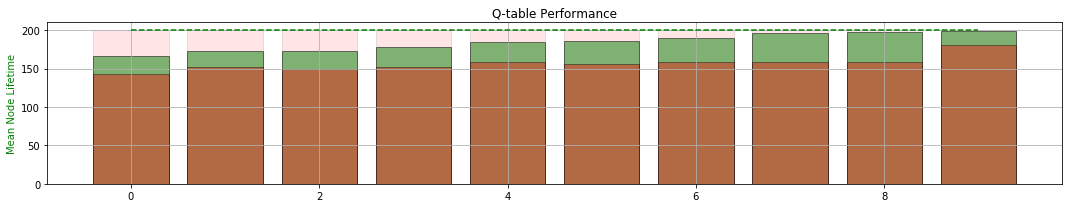

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  7649
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.92
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:49.574518


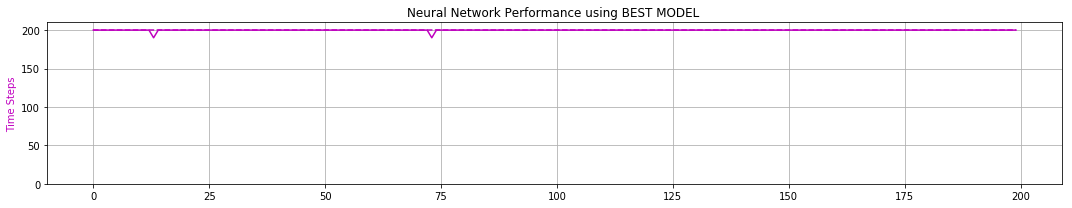

0 -max- [ 0.146  0.542  0.049  0.981  0.550]
0 -min- [-2.399 -2.583 -0.209 -1.000  0.375]

1 -max- [ 0.132  0.439  0.048  0.996  0.600]
1 -min- [-2.400 -2.535 -0.209 -1.129  0.400]

2 -max- [ 0.128  0.430  0.049  0.712  0.650]
2 -min- [-2.396 -2.426 -0.209 -0.805  0.450]

3 -max- [ 0.164  0.588  0.050  0.833  0.700]
3 -min- [-2.399 -2.424 -0.209 -0.895  0.500]

4 -max- [ 0.201  0.570  0.050  0.714  0.750]
4 -min- [-2.399 -2.422 -0.209 -0.801  0.550]

5 -max- [ 0.120  0.626  0.050  0.986  0.799]
5 -min- [-2.399 -2.428 -0.209 -1.075  0.601]

6 -max- [ 0.179  0.439  0.050  0.881  0.849]
6 -min- [-2.400 -2.411 -0.209 -0.823  0.651]

7 -max- [ 0.144  0.439  0.053  0.718  0.900]
7 -min- [-2.400 -2.393 -0.209 -0.831  0.700]

8 -max- [ 0.134  0.439  0.050  0.717  0.925]
8 -min- [-2.396 -2.372 -0.209 -0.966  0.752]

9 -max- [ 0.187  0.630  0.050  0.737  0.925]
9 -min- [-2.398 -2.217 -0.209 -0.799  0.800]



ITERATION # 13
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

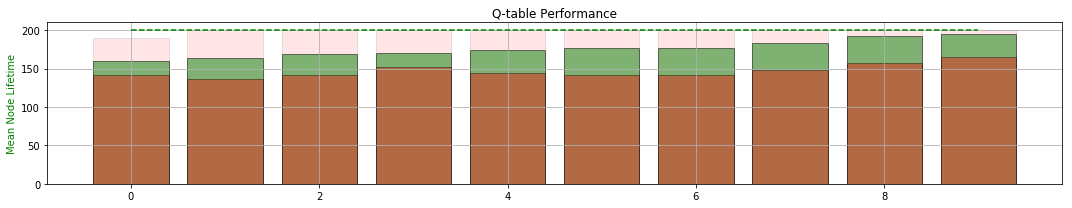

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  8441
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  196.34
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:50.720492


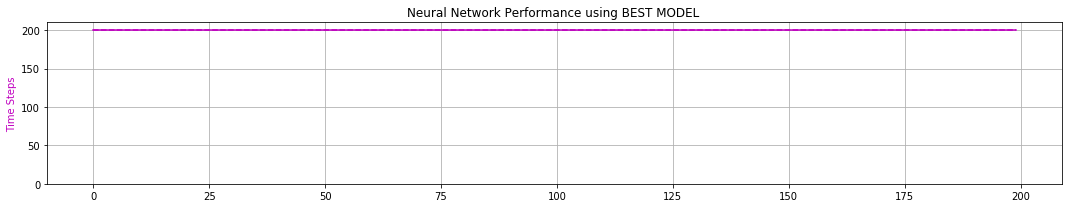

0 -max- [ 0.141  0.439  0.048  0.876  0.549]
0 -min- [-2.400 -2.372 -0.209 -0.924  0.375]

1 -max- [ 0.126  0.438  0.049  0.695  0.600]
1 -min- [-2.398 -2.422 -0.209 -0.806  0.400]

2 -max- [ 0.169  0.438  0.050  0.706  0.649]
2 -min- [-2.398 -2.381 -0.209 -1.135  0.450]

3 -max- [ 0.201  0.627  0.050  0.712  0.699]
3 -min- [-2.399 -2.406 -0.209 -1.132  0.501]

4 -max- [ 0.141  0.626  0.050  0.964  0.749]
4 -min- [-2.400 -2.424 -0.209 -1.024  0.550]

5 -max- [ 0.197  0.619  0.050  0.710  0.800]
5 -min- [-2.399 -2.323 -0.209 -0.805  0.600]

6 -max- [ 0.139  0.568  0.049  0.715  0.849]
6 -min- [-2.400 -2.407 -0.209 -0.967  0.650]

7 -max- [ 0.174  0.431  0.050  0.727  0.900]
7 -min- [-2.398 -2.232 -0.209 -0.848  0.700]

8 -max- [ 0.186  0.440  0.049  0.946  0.925]
8 -min- [-2.400 -2.206 -0.209 -0.833  0.750]

9 -max- [ 0.209  0.443  0.050  0.961  0.925]
9 -min- [-2.398 -2.207 -0.209 -0.795  0.801]



ITERATION # 14
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

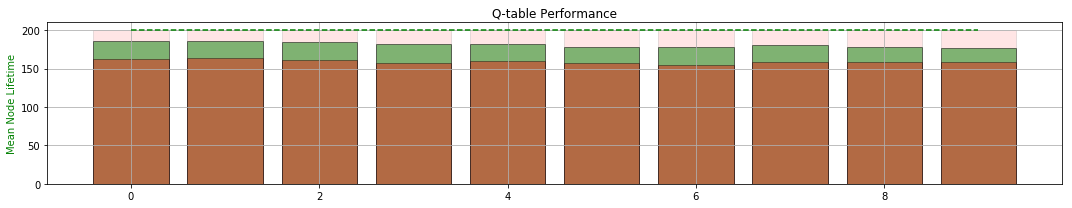

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  9372
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  199.74
Validating... MEAN TIME:  198.915
Validating... MEAN TIME:  198.865
Validating... MEAN TIME:  192.84
Validating... MEAN TIME:  177.405
TRAINING TIME:0:00:49.264488


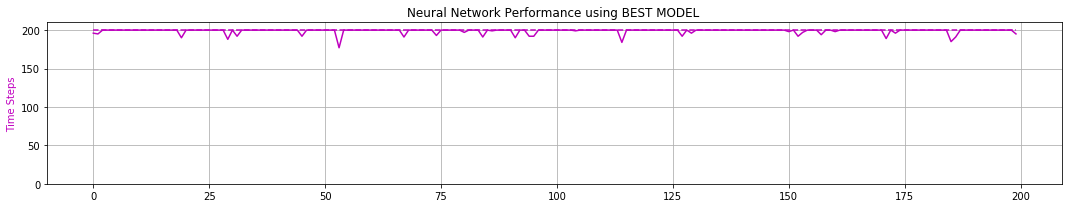

0 -max- [ 0.121  0.434  0.049  0.959  0.549]
0 -min- [-2.398 -2.035 -0.209 -0.996  0.375]

1 -max- [ 0.152  0.612  0.055  1.249  0.600]
1 -min- [-2.396 -2.032 -0.209 -1.115  0.401]

2 -max- [ 0.137  0.592  0.050  0.983  0.650]
2 -min- [-2.398 -2.047 -0.209 -0.956  0.451]

3 -max- [ 0.108  0.591  0.050  0.970  0.700]
3 -min- [-2.395 -2.166 -0.209 -0.916  0.501]

4 -max- [ 0.149  0.439  0.050  0.973  0.749]
4 -min- [-2.400 -2.140 -0.209 -1.031  0.551]

5 -max- [ 0.119  0.624  0.055  1.253  0.800]
5 -min- [-2.400 -2.153 -0.209 -0.984  0.601]

6 -max- [ 0.116  0.634  0.050  0.989  0.850]
6 -min- [-2.399 -2.146 -0.209 -0.977  0.650]

7 -max- [ 0.154  0.630  0.049  0.982  0.900]
7 -min- [-2.399 -2.150 -0.209 -1.025  0.700]

8 -max- [ 0.121  0.439  0.050  1.028  0.925]
8 -min- [-2.399 -2.215 -0.209 -1.034  0.751]

9 -max- [ 0.122  0.618  0.047  0.973  0.925]
9 -min- [-2.400 -2.207 -0.209 -0.914  0.800]



ITERATION # 15
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

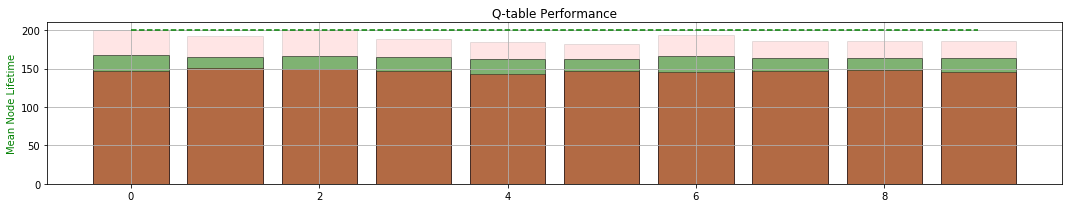

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  10370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  182.825
Validating... MEAN TIME:  179.34
Validating... MEAN TIME:  189.72
Validating... MEAN TIME:  182.825
Validating... MEAN TIME:  172.49
TRAINING TIME:0:00:46.581870


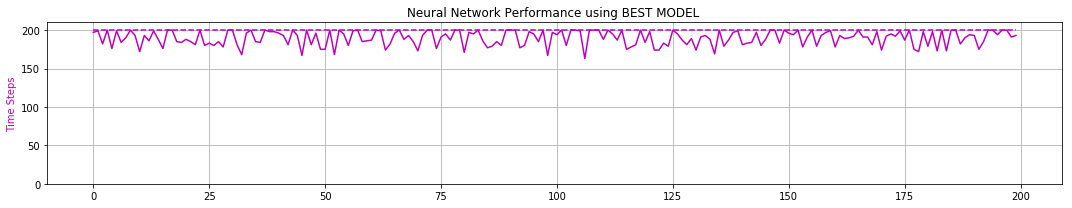

0 -max- [ 0.167  0.610  0.059  0.975  0.550]
0 -min- [-2.400 -2.349 -0.209 -1.015  0.375]

1 -max- [ 0.137  0.798  0.050  1.178  0.600]
1 -min- [-2.398 -2.340 -0.209 -1.172  0.401]

2 -max- [ 0.108  0.553  0.050  1.225  0.650]
2 -min- [-2.391 -2.345 -0.209 -0.980  0.451]

3 -max- [ 0.149  0.635  0.050  0.969  0.700]
3 -min- [-2.390 -2.373 -0.209 -1.050  0.500]

4 -max- [ 0.124  0.597  0.049  0.981  0.749]
4 -min- [-2.400 -2.378 -0.209 -1.020  0.550]

5 -max- [ 0.117  0.440  0.050  0.963  0.798]
5 -min- [-2.399 -2.395 -0.209 -1.063  0.600]

6 -max- [ 0.154  0.545  0.049  1.204  0.848]
6 -min- [-2.399 -2.377 -0.209 -0.970  0.651]

7 -max- [ 0.121  0.596  0.050  0.972  0.899]
7 -min- [-2.398 -2.393 -0.209 -0.947  0.700]

8 -max- [ 0.117  0.631  0.047  1.262  0.925]
8 -min- [-2.400 -2.550 -0.209 -1.095  0.750]

9 -max- [ 0.122  0.628  0.049  1.268  0.925]
9 -min- [-2.398 -2.413 -0.209 -1.002  0.800]



ITERATION # 16
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

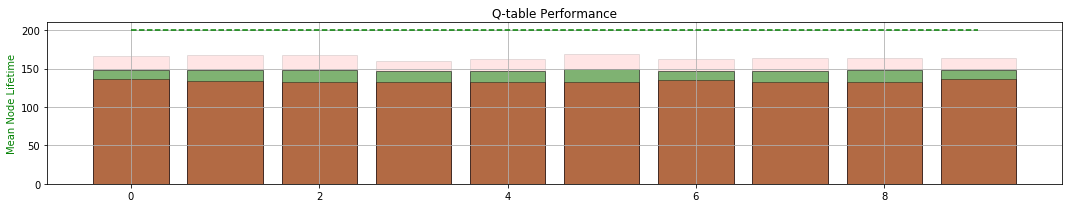

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  11370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  177.215
Validating... MEAN TIME:  154.81
Validating... MEAN TIME:  155.595
Validating... MEAN TIME:  159.95
Validating... MEAN TIME:  157.335
TRAINING TIME:0:00:42.402433


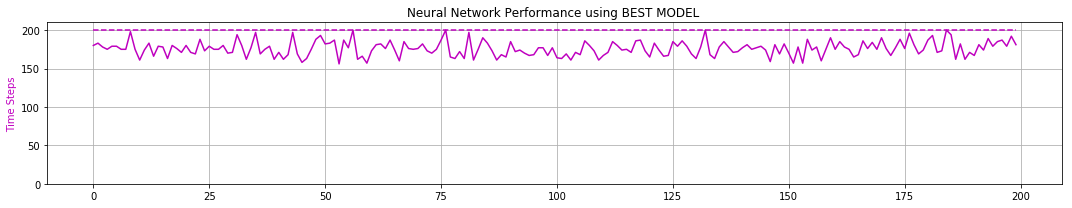

0 -max- [ 0.145  0.437  0.050  0.926  0.550]
0 -min- [-2.400 -2.385 -0.206 -1.044  0.375]

1 -max- [ 0.115  0.581  0.050  0.931  0.600]
1 -min- [-2.399 -2.536 -0.209 -0.859  0.400]

2 -max- [ 0.162  0.605  0.050  0.948  0.650]
2 -min- [-2.400 -2.368 -0.199 -0.940  0.452]

3 -max- [ 0.135  0.631  0.049  0.957  0.700]
3 -min- [-2.400 -2.422 -0.199 -0.954  0.500]

4 -max- [ 0.133  0.591  0.050  0.938  0.750]
4 -min- [-2.399 -2.423 -0.207 -0.903  0.550]

5 -max- [ 0.170  0.633  0.049  0.953  0.800]
5 -min- [-2.400 -2.424 -0.197 -0.896  0.600]

6 -max- [ 0.134  0.632  0.050  0.946  0.849]
6 -min- [-2.400 -2.425 -0.200 -0.901  0.651]

7 -max- [ 0.144  0.632  0.047  0.974  0.900]
7 -min- [-2.399 -2.551 -0.202 -1.053  0.700]

8 -max- [ 0.130  0.622  0.049  1.174  0.925]
8 -min- [-2.400 -2.527 -0.209 -0.947  0.750]

9 -max- [ 0.133  0.745  0.050  1.241  0.925]
9 -min- [-2.400 -2.426 -0.204 -1.120  0.800]



ITERATION # 17
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

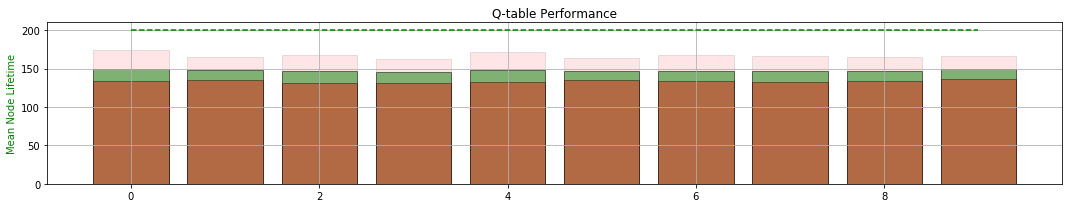

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  12370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  145.48
Validating... MEAN TIME:  171.28
Validating... MEAN TIME:  147.25
Validating... MEAN TIME:  149.56
Validating... MEAN TIME:  151.91
TRAINING TIME:0:00:40.950284


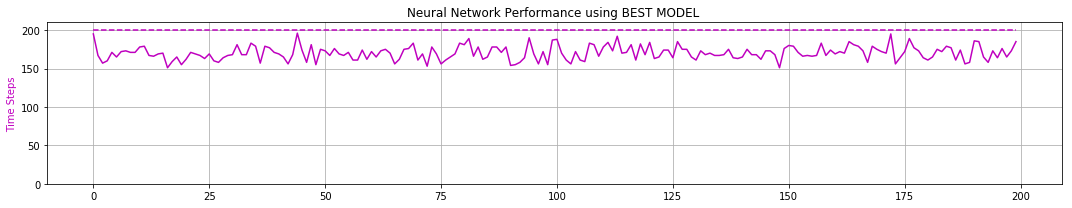

0 -max- [ 0.122  0.437  0.050  0.951  0.548]
0 -min- [-2.400 -2.382 -0.195 -1.086  0.375]

1 -max- [ 0.160  0.567  0.050  0.812  0.599]
1 -min- [-2.400 -2.366 -0.195 -0.873  0.402]

2 -max- [ 0.140  0.439  0.049  1.012  0.650]
2 -min- [-2.400 -2.547 -0.201 -1.020  0.450]

3 -max- [ 0.127  0.601  0.050  0.704  0.700]
3 -min- [-2.399 -2.428 -0.202 -0.912  0.501]

4 -max- [ 0.179  0.610  0.056  0.802  0.750]
4 -min- [-2.399 -2.367 -0.196 -0.968  0.550]

5 -max- [ 0.127  0.603  0.050  0.793  0.800]
5 -min- [-2.400 -2.363 -0.191 -0.918  0.601]

6 -max- [ 0.122  0.627  0.047  0.867  0.850]
6 -min- [-2.400 -2.408 -0.205 -0.996  0.650]

7 -max- [ 0.122  0.576  0.049  0.891  0.900]
7 -min- [-2.400 -2.378 -0.205 -1.000  0.700]

8 -max- [ 0.136  0.613  0.050  0.918  0.925]
8 -min- [-2.400 -2.363 -0.208 -1.064  0.750]

9 -max- [ 0.150  0.617  0.049  0.922  0.925]
9 -min- [-2.400 -2.371 -0.191 -0.995  0.800]



ITERATION # 18
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

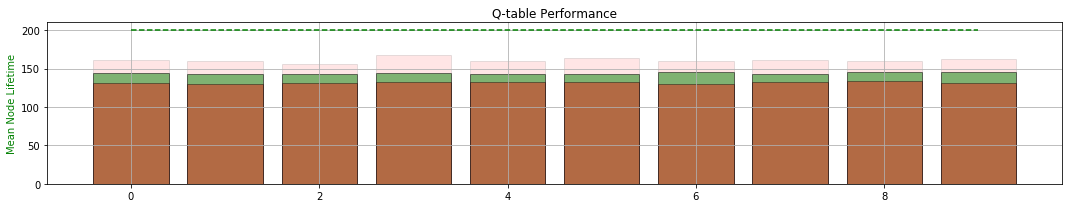

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  13370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  161.61
Validating... MEAN TIME:  151.39
Validating... MEAN TIME:  143.91
Validating... MEAN TIME:  147.78
Validating... MEAN TIME:  153.69
TRAINING TIME:0:00:40.485556


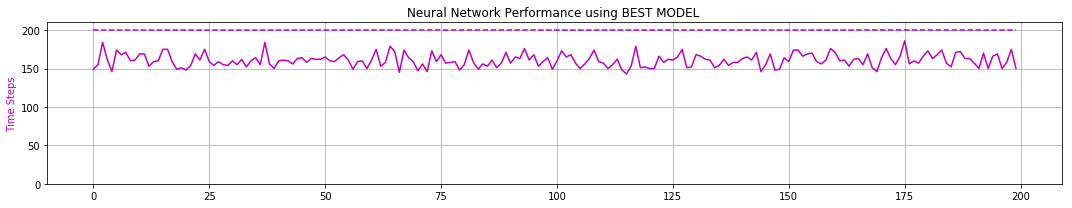

0 -max- [ 0.154  0.543  0.050  0.935  0.549]
0 -min- [-2.400 -2.242 -0.193 -0.811  0.375]

1 -max- [ 0.130  0.598  0.049  0.935  0.600]
1 -min- [-2.400 -2.249 -0.201 -1.314  0.400]

2 -max- [ 0.125  0.627  0.050  0.870  0.650]
2 -min- [-2.399 -2.349 -0.199 -0.986  0.450]

3 -max- [ 0.165  0.591  0.049  0.902  0.699]
3 -min- [-2.400 -2.241 -0.196 -0.898  0.500]

4 -max- [ 0.128  0.590  0.050  0.906  0.750]
4 -min- [-2.400 -2.215 -0.207 -1.076  0.550]

5 -max- [ 0.125  0.629  0.047  0.953  0.798]
5 -min- [-2.400 -2.212 -0.208 -1.026  0.600]

6 -max- [ 0.128  0.740  0.049  1.229  0.850]
6 -min- [-2.400 -2.425 -0.196 -1.187  0.650]

7 -max- [ 0.136  0.572  0.050  0.946  0.900]
7 -min- [-2.400 -2.208 -0.199 -0.953  0.700]

8 -max- [ 0.155  0.735  0.049  0.959  0.925]
8 -min- [-2.399 -2.221 -0.190 -1.128  0.750]

9 -max- [ 0.159  0.611  0.049  0.958  0.925]
9 -min- [-2.400 -2.344 -0.194 -0.937  0.800]



ITERATION # 19
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

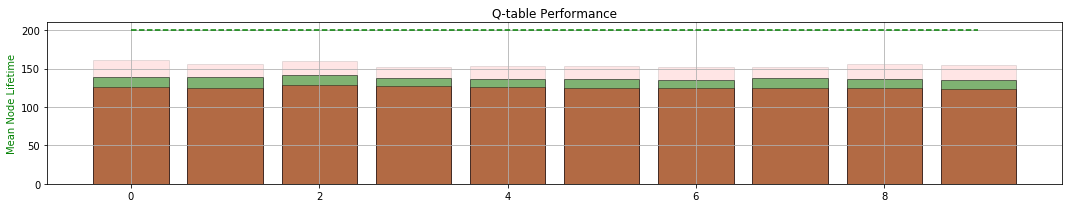

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  14370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  139.855
Validating... MEAN TIME:  147.865
Validating... MEAN TIME:  147.335
Validating... MEAN TIME:  139.325
Validating... MEAN TIME:  141.35
TRAINING TIME:0:00:38.631666


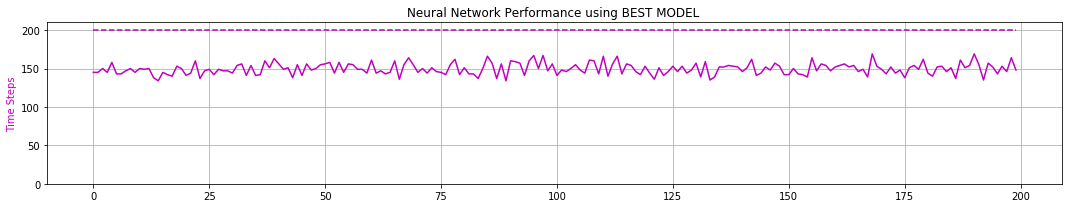

0 -max- [ 0.133  0.634  0.049  0.991  0.549]
0 -min- [-2.400 -2.430 -0.199 -1.055  0.375]

1 -max- [ 0.127  0.632  0.050  0.929  0.600]
1 -min- [-2.400 -2.360 -0.197 -0.922  0.400]

2 -max- [ 0.173  0.612  0.049  1.005  0.650]
2 -min- [-2.400 -2.367 -0.201 -0.939  0.450]

3 -max- [ 0.131  0.624  0.050  0.905  0.700]
3 -min- [-2.400 -2.353 -0.199 -0.906  0.500]

4 -max- [ 0.126  0.637  0.047  0.923  0.750]
4 -min- [-2.399 -2.436 -0.203 -0.884  0.551]

5 -max- [ 0.134  0.627  0.049  0.936  0.799]
5 -min- [-2.400 -2.363 -0.198 -1.012  0.600]

6 -max- [ 0.144  0.630  0.050  0.935  0.850]
6 -min- [-2.400 -2.414 -0.207 -1.078  0.650]

7 -max- [ 0.155  0.623  0.049  1.003  0.899]
7 -min- [-2.400 -2.367 -0.193 -1.117  0.700]

8 -max- [ 0.177  0.612  0.049  0.963  0.925]
8 -min- [-2.400 -2.385 -0.206 -0.893  0.750]

9 -max- [ 0.169  0.615  0.054  1.018  0.925]
9 -min- [-2.399 -2.368 -0.195 -1.016  0.800]



ITERATION # 20
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

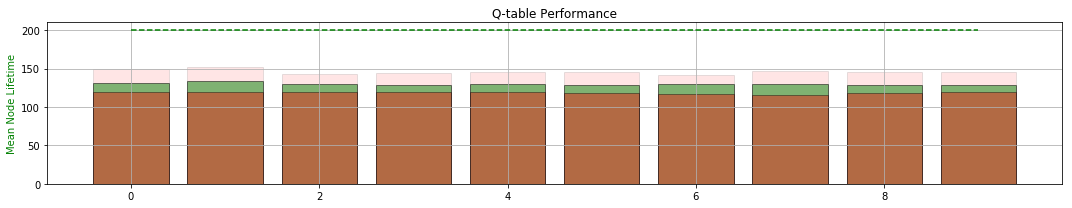

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  15370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  134.345
Validating... MEAN TIME:  127.82
Validating... MEAN TIME:  132.455
Validating... MEAN TIME:  134.175
Validating... MEAN TIME:  126.6
TRAINING TIME:0:00:35.777047


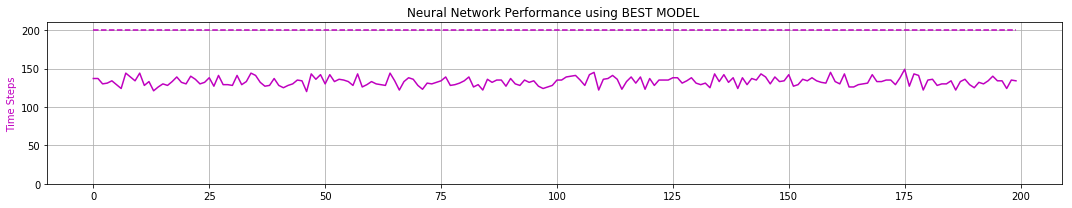

0 -max- [ 0.127  0.625  0.050  0.929  0.550]
0 -min- [-2.400 -2.411 -0.200 -1.040  0.375]

1 -max- [ 0.173  0.584  0.049  0.801  0.600]
1 -min- [-2.400 -2.399 -0.204 -0.986  0.400]

2 -max- [ 0.136  0.628  0.050  0.670  0.649]
2 -min- [-2.400 -2.428 -0.192 -0.956  0.450]

3 -max- [ 0.134  0.631  0.047  0.995  0.700]
3 -min- [-2.400 -2.434 -0.201 -1.098  0.500]

4 -max- [ 0.128  0.617  0.049  1.172  0.749]
4 -min- [-2.399 -2.528 -0.202 -0.985  0.550]

5 -max- [ 0.148  0.632  0.056  0.938  0.800]
5 -min- [-2.400 -2.431 -0.201 -1.093  0.600]

6 -max- [ 0.161  0.616  0.049  0.938  0.850]
6 -min- [-2.399 -2.366 -0.201 -1.023  0.651]

7 -max- [ 0.161  0.576  0.049  0.914  0.900]
7 -min- [-2.400 -2.557 -0.198 -1.041  0.700]

8 -max- [ 0.188  0.570  0.050  0.951  0.925]
8 -min- [-2.400 -2.424 -0.194 -1.032  0.750]

9 -max- [ 0.165  0.633  0.049  0.996  0.925]
9 -min- [-2.399 -2.412 -0.190 -0.991  0.800]



ITERATION # 21
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

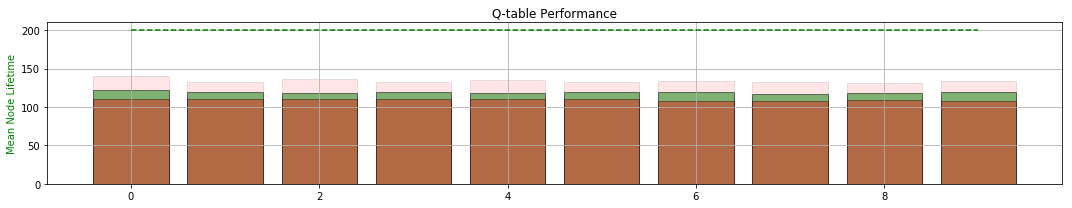

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  16370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  119.57
Validating... MEAN TIME:  117.5
Validating... MEAN TIME:  124.4
Validating... MEAN TIME:  119.355
Validating... MEAN TIME:  118.96
TRAINING TIME:0:00:33.639747


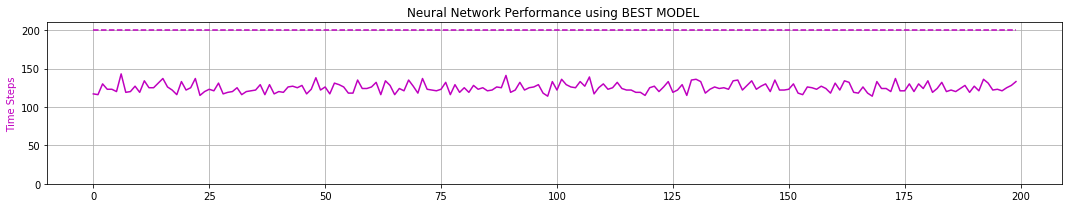

0 -max- [ 0.174  0.632  0.049  1.071  0.549]
0 -min- [-2.400 -2.527 -0.193 -0.943  0.375]

1 -max- [ 0.142  0.556  0.050  0.887  0.599]
1 -min- [-2.400 -2.600 -0.194 -0.956  0.400]

2 -max- [ 0.138  0.631  0.056  0.947  0.648]
2 -min- [-2.399 -2.581 -0.198 -1.071  0.450]

3 -max- [ 0.136  0.559  0.049  1.127  0.699]
3 -min- [-2.400 -2.594 -0.198 -1.007  0.500]

4 -max- [ 0.150  0.608  0.053  1.173  0.749]
4 -min- [-2.400 -2.603 -0.197 -0.988  0.550]

5 -max- [ 0.168  0.586  0.049  0.986  0.800]
5 -min- [-2.400 -2.721 -0.198 -1.120  0.600]

6 -max- [ 0.172  0.629  0.049  0.962  0.849]
6 -min- [-2.400 -2.578 -0.196 -0.959  0.651]

7 -max- [ 0.180  0.616  0.050  1.157  0.899]
7 -min- [-2.400 -2.607 -0.201 -0.954  0.700]

8 -max- [ 0.172  0.574  0.055  0.971  0.925]
8 -min- [-2.399 -2.550 -0.204 -1.062  0.752]

9 -max- [ 0.175  0.627  0.050  0.935  0.925]
9 -min- [-2.400 -2.542 -0.208 -1.217  0.800]



ITERATION # 22
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

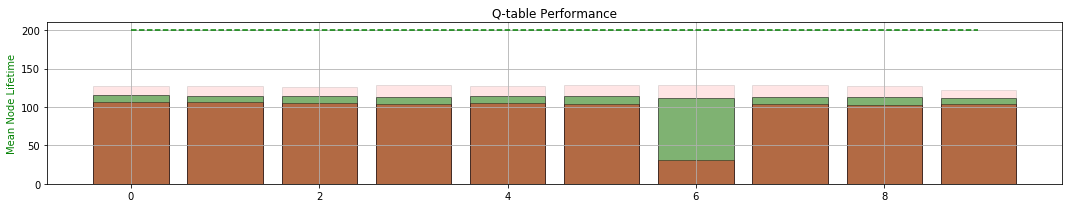

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  17370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  116.53
Validating... MEAN TIME:  116.325
Validating... MEAN TIME:  112.35
Validating... MEAN TIME:  114.035
Validating... MEAN TIME:  117.315
TRAINING TIME:0:00:32.916052


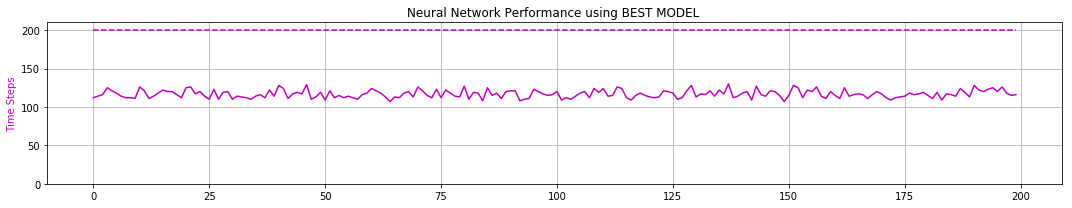

0 -max- [ 0.142  0.610  0.050  1.320  0.549]
0 -min- [-2.400 -2.718 -0.200 -1.066  0.375]

1 -max- [ 0.139  0.601  0.047  1.010  0.600]
1 -min- [-2.399 -2.749 -0.208 -1.017  0.400]

2 -max- [ 0.144  0.627  0.049  1.024  0.650]
2 -min- [-2.399 -2.598 -0.203 -1.086  0.450]

3 -max- [ 0.152  0.634  0.050  0.979  0.700]
3 -min- [-2.400 -2.606 -0.197 -0.959  0.501]

4 -max- [ 0.168  0.626  0.049  0.982  0.750]
4 -min- [-2.400 -2.725 -0.209 -1.079  0.550]

5 -max- [ 0.180  0.588  0.049  1.197  0.799]
5 -min- [-2.400 -2.742 -0.208 -1.033  0.601]

6 -max- [ 0.185  0.630  0.050  0.994  0.850]
6 -min- [-2.400 -2.719 -0.208 -1.125  0.650]

7 -max- [ 0.172  0.567  0.049  0.902  0.900]
7 -min- [-2.400 -2.732 -0.208 -1.026  0.701]

8 -max- [ 0.183  0.638  0.050  1.003  0.925]
8 -min- [-2.400 -2.726 -0.196 -0.954  0.750]

9 -max- [ 0.149  0.633  0.049  0.905  0.925]
9 -min- [-2.400 -2.613 -0.196 -0.988  0.800]



ITERATION # 23
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

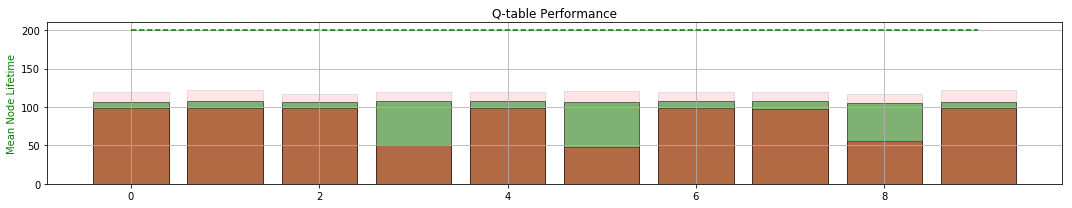

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  18370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  107.605
Validating... MEAN TIME:  107.12
Validating... MEAN TIME:  108.365
Validating... MEAN TIME:  108.145
Validating... MEAN TIME:  109.145
TRAINING TIME:0:00:31.281440


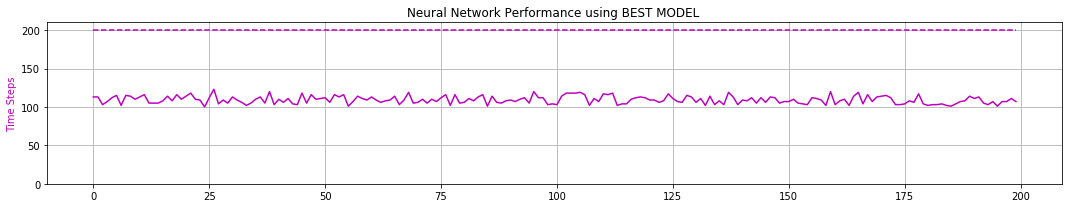

0 -max- [ 0.153  0.629  0.047  0.927  0.550]
0 -min- [-2.400 -2.936 -0.196 -0.979  0.375]

1 -max- [ 0.158  0.640  0.057  0.789  0.600]
1 -min- [-2.399 -2.910 -0.202 -1.043  0.400]

2 -max- [ 0.164  0.583  0.050  0.954  0.649]
2 -min- [-2.400 -2.916 -0.199 -0.949  0.450]

3 -max- [ 0.184  0.789  0.049  0.914  0.700]
3 -min- [-2.400 -2.781 -0.209 -1.276  0.500]

4 -max- [ 0.195  0.619  0.049  0.848  0.749]
4 -min- [-2.400 -2.954 -0.201 -1.068  0.550]

5 -max- [ 0.193  0.581  0.050  0.981  0.800]
5 -min- [-2.399 -2.768 -0.207 -1.051  0.601]

6 -max- [ 0.175  0.601  0.049  0.917  0.849]
6 -min- [-2.400 -2.737 -0.190 -1.034  0.651]

7 -max- [ 0.191  0.581  0.050  0.909  0.900]
7 -min- [-2.399 -2.915 -0.203 -1.443  0.700]

8 -max- [ 0.154  0.637  0.049  0.711  0.925]
8 -min- [-2.399 -2.718 -0.209 -1.041  0.751]

9 -max- [ 0.161  0.636  0.051  0.932  0.925]
9 -min- [-2.400 -2.786 -0.199 -1.034  0.800]



ITERATION # 24
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

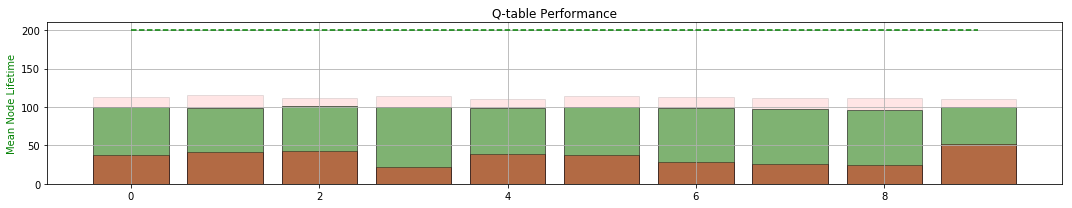

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  19370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  102.665
Validating... MEAN TIME:  101.43
Validating... MEAN TIME:  102.175
Validating... MEAN TIME:  100.18
Validating... MEAN TIME:  101.605
TRAINING TIME:0:00:30.715351


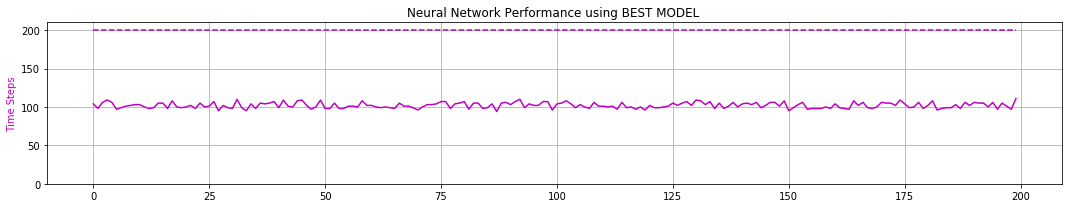

0 -max- [ 0.159  0.630  0.049  1.028  0.550]
0 -min- [-2.399 -2.947 -0.209 -1.039  0.375]

1 -max- [ 0.176  0.625  0.050  0.810  0.600]
1 -min- [-2.400 -2.973 -0.209 -1.095  0.401]

2 -max- [ 0.192  0.579  0.049  0.867  0.649]
2 -min- [-2.400 -2.949 -0.207 -0.917  0.450]

3 -max- [ 0.203  0.634  0.049  0.968  0.700]
3 -min- [-2.399 -2.965 -0.208 -1.177  0.501]

4 -max- [ 0.208  0.638  0.050  0.808  0.750]
4 -min- [-2.400 -2.925 -0.209 -0.998  0.550]

5 -max- [ 0.196  0.573  0.049  0.853  0.799]
5 -min- [-2.399 -2.920 -0.205 -1.044  0.600]

6 -max- [ 0.199  0.617  0.050  0.877  0.850]
6 -min- [-2.398 -2.958 -0.207 -1.054  0.650]

7 -max- [ 0.170  0.623  0.049  0.828  0.899]
7 -min- [-2.400 -2.954 -0.208 -1.055  0.701]

8 -max- [ 0.177  0.748  0.050  0.927  0.925]
8 -min- [-2.400 -2.973 -0.209 -1.199  0.750]

9 -max- [ 0.173  0.626  0.049  0.974  0.925]
9 -min- [-2.399 -2.947 -0.203 -1.075  0.800]



ITERATION # 25
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

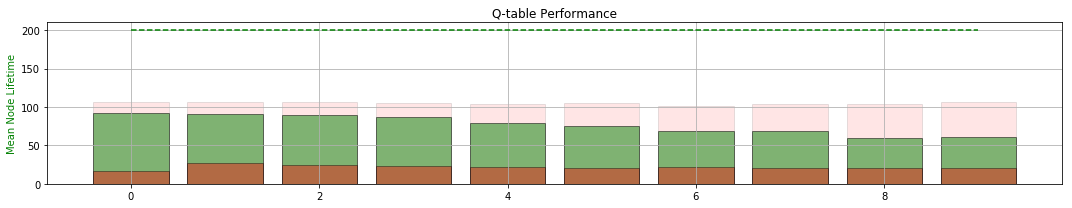

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  20370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  98.035
Validating... MEAN TIME:  99.1
Validating... MEAN TIME:  98.32
Validating... MEAN TIME:  99.53
Validating... MEAN TIME:  99.27
TRAINING TIME:0:00:30.124374


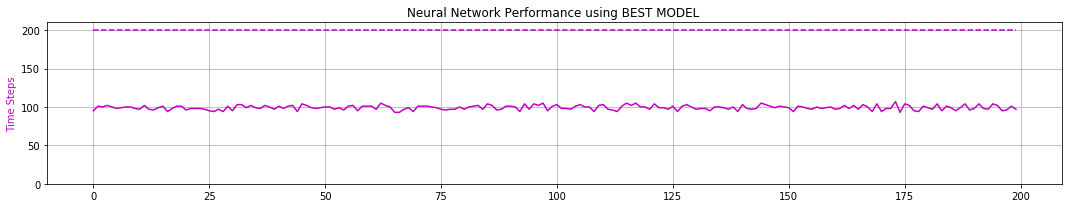

0 -max- [ 0.172  0.632  0.050  0.642  0.549]
0 -min- [-2.399 -3.241 -0.209 -1.080  0.375]

1 -max- [ 0.192  0.765  0.049  0.746  0.599]
1 -min- [-2.400 -3.131 -0.209 -1.211  0.400]

2 -max- [ 0.194  0.632  0.051  0.632  0.650]
2 -min- [-2.399 -3.123 -0.209 -1.086  0.451]

3 -max- [ 0.198  0.637  0.050  0.775  0.699]
3 -min- [-2.400 -3.278 -0.209 -1.074  0.500]

4 -max- [ 0.186  0.829  0.049  0.662  0.748]
4 -min- [-2.399 -3.121 -0.209 -1.149  0.551]

5 -max- [ 0.202  0.773  0.050  0.671  0.800]
5 -min- [-2.400 -3.122 -0.209 -1.179  0.601]

6 -max- [ 0.171  0.764  0.049  0.763  0.849]
6 -min- [-2.400 -3.073 -0.209 -1.108  0.650]

7 -max- [ 0.175  0.632  0.050  0.677  0.900]
7 -min- [-2.400 -3.087 -0.209 -1.111  0.701]

8 -max- [ 0.180  0.634  0.049  0.638  0.925]
8 -min- [-2.400 -3.127 -0.209 -1.057  0.750]

9 -max- [ 0.193  0.633  0.050  0.768  0.925]
9 -min- [-2.397 -3.068 -0.209 -1.013  0.801]



ITERATION # 26
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

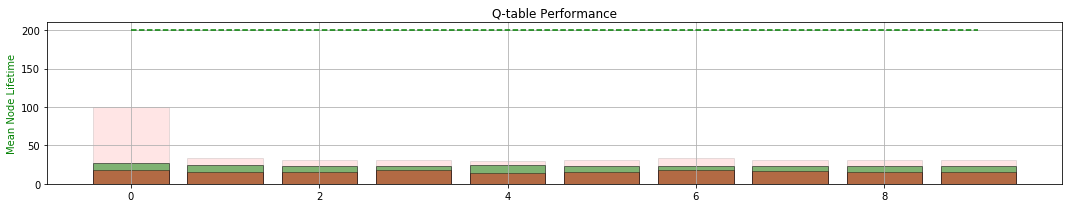

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  21370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  100.59
Validating... MEAN TIME:  99.455
Validating... MEAN TIME:  96.98
Validating... MEAN TIME:  97.415
Validating... MEAN TIME:  97.08
TRAINING TIME:0:00:29.632332


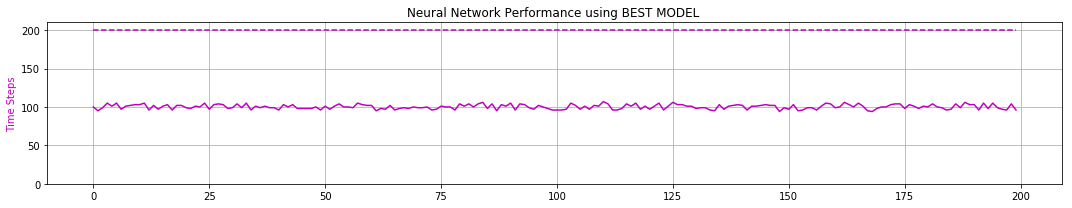

0 -max- [ 0.202  0.766  0.049  0.703  0.550]
0 -min- [-2.384 -2.963 -0.209 -1.214  0.375]

1 -max- [ 0.208  0.787  0.049  0.335  0.600]
1 -min- [-0.050 -0.781 -0.209 -1.186  0.402]

2 -max- [ 0.220  0.825  0.050  0.320  0.649]
2 -min- [-0.049 -0.598 -0.209 -1.178  0.450]

3 -max- [ 0.192  0.756  0.049  0.327  0.699]
3 -min- [-0.047 -0.567 -0.209 -1.179  0.500]

4 -max- [ 0.208  0.636  0.050  0.072  0.750]
4 -min- [-0.050 -0.588 -0.209 -1.018  0.550]

5 -max- [ 0.179  0.635  0.049  0.072  0.800]
5 -min- [-0.050 -0.586 -0.209 -0.974  0.600]

6 -max- [ 0.189  0.821  0.050  0.311  0.850]
6 -min- [-0.050 -0.594 -0.209 -1.102  0.650]

7 -max- [ 0.186  0.636  0.049  0.250  0.900]
7 -min- [-0.050 -0.781 -0.209 -1.118  0.700]

8 -max- [ 0.200  0.814  0.050  0.295  0.925]
8 -min- [-0.047 -0.586 -0.209 -1.259  0.750]

9 -max- [ 0.198  0.826  0.050  0.233  0.925]
9 -min- [-0.049 -0.596 -0.209 -1.175  0.801]



ITERATION # 27
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

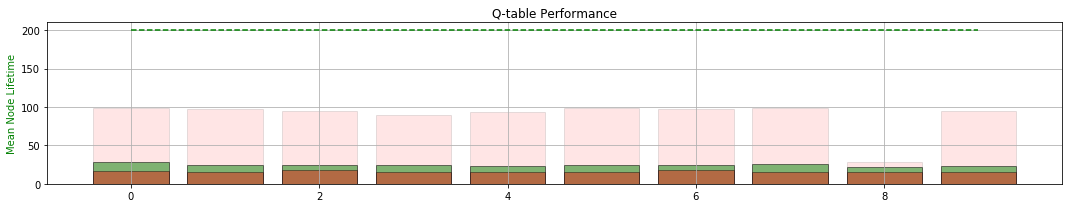

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  22370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  98.985
Validating... MEAN TIME:  98.625
Validating... MEAN TIME:  99.01
Validating... MEAN TIME:  99.355
Validating... MEAN TIME:  101.51
TRAINING TIME:0:00:30.215697


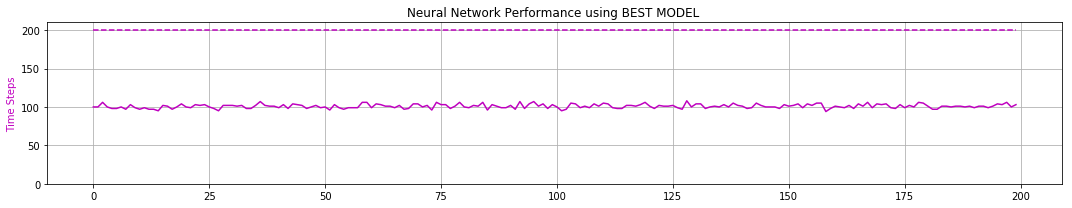

0 -max- [ 0.208  0.813  0.049  0.625  0.550]
0 -min- [-2.388 -2.946 -0.209 -1.202  0.375]

1 -max- [ 0.207  0.749  0.050  0.664  0.599]
1 -min- [-2.387 -2.935 -0.209 -1.167  0.400]

2 -max- [ 0.194  0.635  0.049  0.621  0.649]
2 -min- [-2.354 -2.763 -0.209 -1.116  0.451]

3 -max- [ 0.210  0.829  0.050  0.573  0.700]
3 -min- [-2.358 -2.762 -0.209 -1.175  0.500]

4 -max- [ 0.179  0.759  0.049  0.559  0.749]
4 -min- [-2.382 -2.956 -0.209 -1.268  0.550]

5 -max- [ 0.191  0.817  0.050  0.557  0.799]
5 -min- [-2.396 -2.941 -0.209 -1.214  0.602]

6 -max- [ 0.190  0.743  0.049  0.480  0.850]
6 -min- [-2.398 -2.896 -0.209 -1.205  0.651]

7 -max- [ 0.207  0.813  0.050  0.552  0.899]
7 -min- [-2.373 -2.885 -0.209 -1.254  0.700]

8 -max- [ 0.198  0.810  0.050  0.330  0.925]
8 -min- [-0.049 -0.786 -0.209 -1.179  0.750]

9 -max- [ 0.183  0.735  0.049  0.559  0.925]
9 -min- [-2.356 -2.777 -0.209 -1.191  0.800]



ITERATION # 28
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

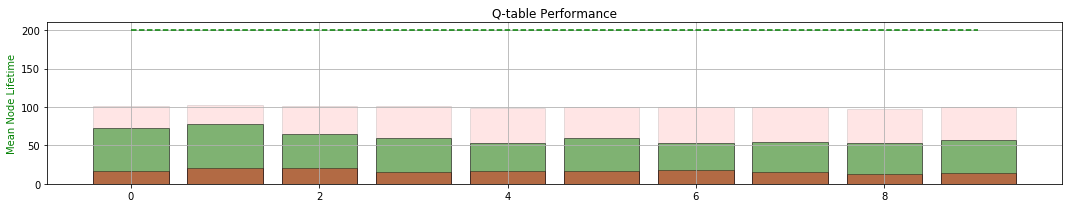

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  23370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  100.02
Validating... MEAN TIME:  97.95
Validating... MEAN TIME:  100.79
Validating... MEAN TIME:  98.86
Validating... MEAN TIME:  98.495
TRAINING TIME:0:00:30.359729


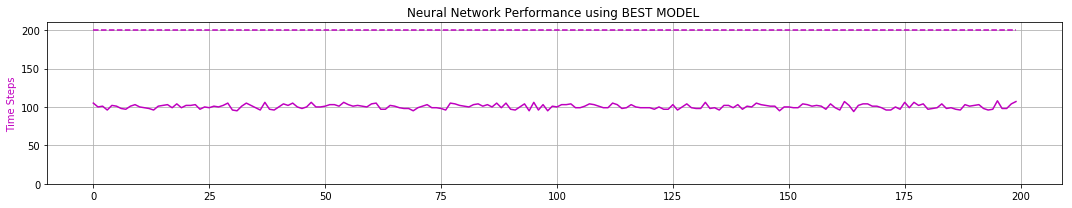

0 -max- [ 0.201  0.799  0.050  0.659  0.550]
0 -min- [-2.400 -3.132 -0.209 -1.241  0.375]

1 -max- [ 0.189  0.635  0.049  0.642  0.600]
1 -min- [-2.400 -3.144 -0.209 -0.977  0.400]

2 -max- [ 0.204  0.805  0.050  0.603  0.649]
2 -min- [-2.400 -3.125 -0.209 -1.239  0.451]

3 -max- [ 0.186  0.807  0.049  0.590  0.700]
3 -min- [-2.397 -3.136 -0.209 -1.331  0.501]

4 -max- [ 0.185  0.820  0.050  0.621  0.750]
4 -min- [-2.399 -3.083 -0.209 -1.255  0.550]

5 -max- [ 0.188  0.811  0.049  0.589  0.799]
5 -min- [-2.400 -3.066 -0.209 -1.162  0.601]

6 -max- [ 0.195  0.817  0.050  0.608  0.849]
6 -min- [-2.400 -3.063 -0.209 -1.139  0.650]

7 -max- [ 0.194  0.828  0.050  0.596  0.900]
7 -min- [-2.400 -2.889 -0.209 -1.245  0.700]

8 -max- [ 0.178  0.823  0.049  0.625  0.925]
8 -min- [-2.398 -3.078 -0.209 -1.219  0.750]

9 -max- [ 0.199  0.824  0.048  0.596  0.925]
9 -min- [-2.400 -2.967 -0.209 -1.323  0.801]



ITERATION # 29
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.01
SMALLEST TIMESTEP in

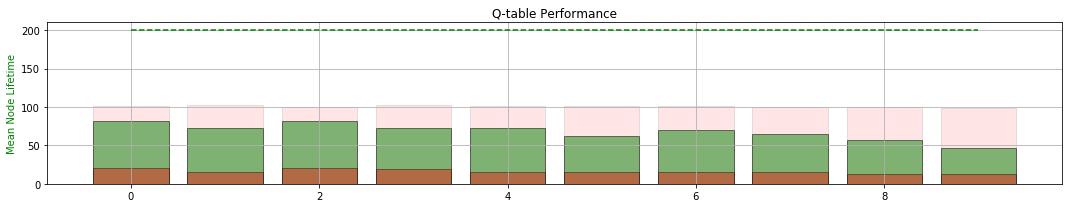

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  24370
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  97.67
Validating... MEAN TIME:  98.16
Validating... MEAN TIME:  95.22
Validating... MEAN TIME:  96.38
Validating... MEAN TIME:  93.945
TRAINING TIME:0:00:29.561566


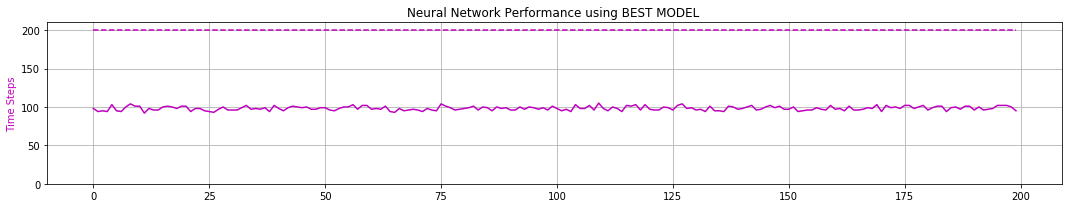

0 -max- [ 0.189  0.825  0.049  0.834  0.549]
0 -min- [-2.400 -3.140 -0.209 -1.213  0.375]

1 -max- [ 0.201  0.636  0.055  0.652  0.599]
1 -min- [-2.399 -3.126 -0.209 -1.125  0.401]

2 -max- [ 0.177  0.793  0.049  0.677  0.650]
2 -min- [-2.398 -3.142 -0.209 -1.297  0.451]

3 -max- [ 0.185  0.825  0.050  0.665  0.700]
3 -min- [-2.400 -3.084 -0.209 -1.287  0.500]

4 -max- [ 0.191  0.819  0.049  0.641  0.750]
4 -min- [-2.400 -3.069 -0.209 -1.189  0.550]

5 -max- [ 0.196  0.827  0.050  0.673  0.799]
5 -min- [-2.399 -3.072 -0.209 -1.183  0.601]

6 -max- [ 0.194  0.825  0.050  0.654  0.850]
6 -min- [-2.400 -3.063 -0.209 -1.270  0.650]

7 -max- [ 0.176  0.823  0.049  0.569  0.900]
7 -min- [-2.400 -3.086 -0.209 -1.177  0.700]

8 -max- [ 0.199  0.829  0.048  0.670  0.925]
8 -min- [-2.397 -3.113 -0.209 -1.237  0.750]

9 -max- [ 0.196  0.829  0.050  0.657  0.925]
9 -min- [-2.396 -3.084 -0.209 -1.210  0.801]



In [19]:
while iteration < MAX_NO_OF_ITERATIONS:
    if iteration < 3:
        node_EPSILON   = (iteration+1) * 0.2
    else:
        node_EPSILON   = T_EPSILON
    
    print("\n")
    print("ITERATION #", iteration)
    print("MEAN TABULAR EPSILON = ", node_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
    bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


    dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
    dqn.good_memory_counter += good_mem.shape[0]

    dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
    dqn.bad_memory_counter += bad_mem.shape[0]

    dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
    dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS

    print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
    print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    start = timeit.default_timer()
    for node_id in range(NO_OF_NODES):
#         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
#         ###############################################
        [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
         C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
#         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
        node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
                                    C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
#         # CREATE STATE COMBINATIONS
#         ###############################################

#         node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN ],
#                                             [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX ],
#                                             [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################

#         # GET Q-VALUES 
#         %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#         # SAVE QFILE
#         node_QFILE = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#         np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
#     print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [20]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  4887.0
Total Serial Timesteps   :  3856195.0
Speed-up                 :  789.07


In [21]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [22]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

   161 FAILURE  13  30    4887    3856195     789.07
